In [6]:
import xarray as xr

In [7]:
pwd

'/home/jovyan/Tjaernoe2022-group1_2nd/notebooks/Ingvild'

In [18]:
data1 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part1.nc4')
data2 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part2.nc4')

In [22]:
data1.cloud_particle_size_distribution

<xarray.DataArray 'cloud_particle_size_distribution' (time: 83755,
                                                      cloud_diameters: 43)>
array([[1.896982, 3.082426, 2.778608, ..., 1.599814, 1.766618, 2.131093],
       [0.83001 , 1.258907, 1.100554, ..., 0.884721, 0.61791 , 1.015153],
       [0.823218, 0.858281, 0.982679, ..., 0.605335, 0.543575, 0.99451 ],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * time             (time) datetime64[ns] 2015-11-27T08:23:25 ... 2018-02-04...
  * cloud_diameters  (cloud_diameters) float64 3.464e-06 4.472e-06 ... 4.599e-05
Attributes:
    long_name:   Cloud particle number size distribution (dN/dlogD)
    instrument:  Fog monitor (FM-120, DMT)
    units:       cm-3
    contact:     Makoto Koike, University of Tokyo
    history:     Averaged (mean) from 10s time resolution down to DMPS time r...

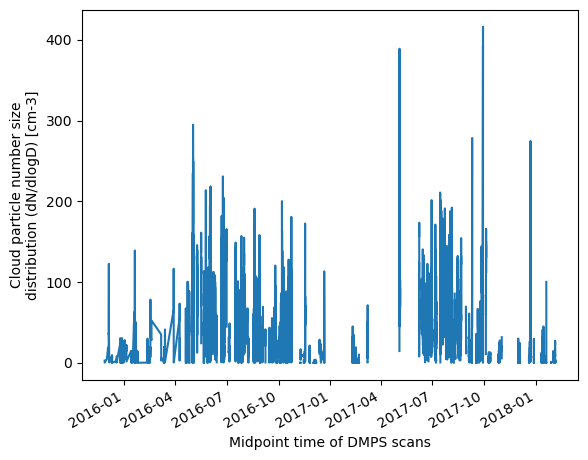

In [24]:
data1['cloud_particle_size_distribution'].mean('cloud_diameters', keep_attrs=True).plot(x ='time')

In [5]:
data1#['aerosol_particle_size_distribution']

<xarray.Dataset>
Dimensions:                                        (time: 83755,
                                                    aerosol_diameters: 30,
                                                    cloud_diameters: 43,
                                                    boundaries: 2,
                                                    target_classification: 11)
Coordinates:
  * time                                           (time) datetime64[ns] 2015...
  * aerosol_diameters                              (aerosol_diameters) float64 ...
  * cloud_diameters                                (cloud_diameters) float64 ...
  * boundaries                                     (boundaries) object 'left'...
  * target_classification                          (target_classification) object ...
Data variables: (12/17)
    aerosol_particle_size_distribution             (time, aerosol_diameters) float64 ...
    total_aerosol_particle_concentration           (time) float64 ...
    cloud_flag                                     (time) object ...
    enrichment_factor                              (time) float64 ...
    transmission_efficiency_factor                 (time) float64 ...
    cluster                                        (time) float64 ...
    ...                                             ...
    temperature                                    (time) float64 ...
    wind_direction                                 (time) float64 ...
    wind_speed                                     (time) float64 ...
    updraft_velocity                               (time) float64 ...
    time_bounds                                    (time, boundaries) datetime64[ns] ...
    normalised_target_classification               (time, target_classification) float64 ...
Attributes:
    title:       Cloud and aerosol measurements from Zeppelin Observatory, Sv...
    authors:     Linn Karlsson, Paul Zieger, Radovan Krejci, Makoto Koike, Ke...
    contact:     Paul Zieger, paul.zieger@aces.su.se
    site:        Zeppelin Observatory, Svalbard, 78.9N 11.9E
    comment:     This is one of two files that together contain all data that...
    start_date:  2015-11-27
    end_date:    2018-02-04
    version:     1.0
    history:     2021-05-06 created

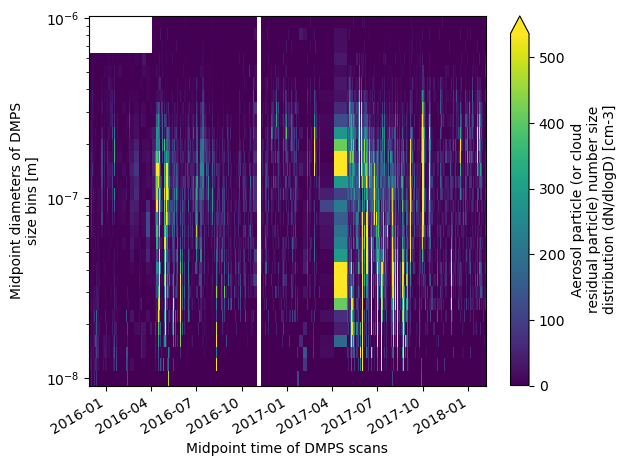

In [19]:
data1['aerosol_particle_size_distribution'].plot(x ='time', robust=True, yscale='log')

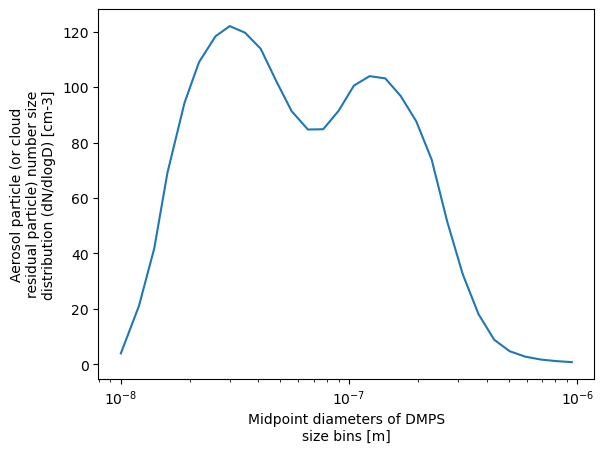

In [23]:
data1['aerosol_particle_size_distribution'].mean('time', keep_attrs=True).plot(xscale='log')#x ='time', robust=True, yscale='log')

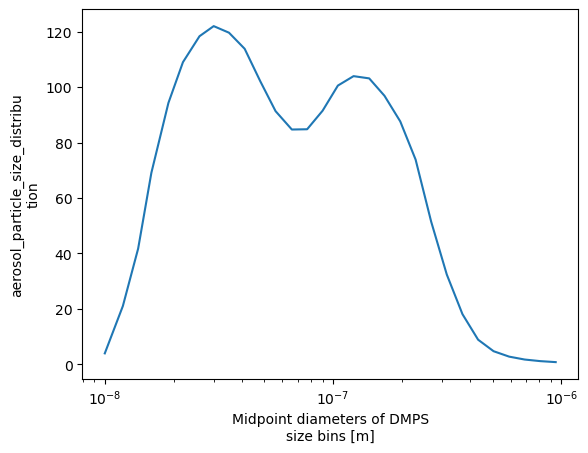

In [24]:
data1['aerosol_particle_size_distribution'].mean('time').plot(xscale='log')

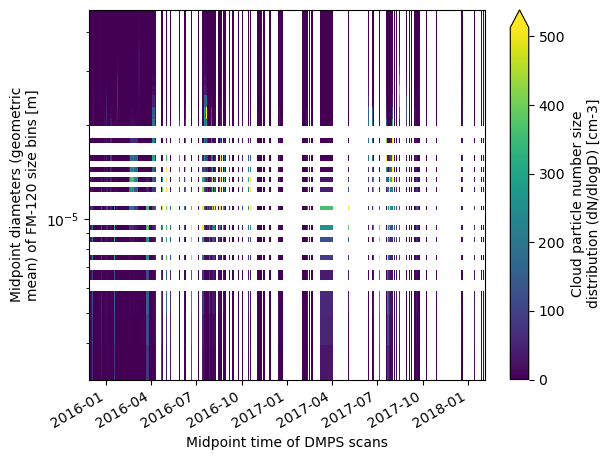

In [17]:
data1['cloud_particle_size_distribution'].plot(x='time', yscale='log', robust=True)